In [1]:
import keras
from keras import layers
from keras import ops

import matplotlib.pyplot as plt

In [2]:
import pickle
import random

with open("images(224).pkl", "rb") as fp:
    new_data = pickle.load(fp)

random.shuffle(new_data)


In [3]:
import numpy as np
images = np.array([item[0] for item in new_data])
labels = np.array([item[1] for item in new_data])
new_data = []

In [4]:
images.shape, labels.shape

((1500, 224, 224), (1500,))

In [5]:
images= np.expand_dims(images, axis=-1)
labels = np.expand_dims(labels, axis=-1)
images.shape, labels.shape

((1500, 224, 224, 1), (1500, 1))

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [7]:
num_classes = len(np.unique(y_train)) 
input_shape = x_train[0].shape
input_shape, num_classes

((224, 224, 1), 3)

In [8]:
# input_shape=(1024,1024,1)
input_shape=(224, 224, 1)
num_classes=3
weight_decay = 0.0001#change weight_decay from .0001 to .001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 128
num_epochs = 10
patch_size = 10  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2 # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64 # dimensionality of the hidden layers(each have 64 nodes) in MLP 
dim_coefficient = 4 # dimensionality of the embeddings_dim is scaled by a factor of 4
num_heads = 4 # self-attention mechanism is divided into 4 heads. 
attention_dropout = 0.2 #to prevent overfitting and improve generalization performance
# Setting attention_dropout = 0.2 means that during training, each element of the attention 
# scores will be set to zero with a probability of 0.2
projection_dropout = 0.2#dropout rate applied to the output of the multi-head self-attention
# mechanism before feeding it into the feedforward neural network layer within the transformer model.
# The remaining elements will be scaled by a factor of 1/(1 - dropout_rate) to maintain the expected sum of the attention scores
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")


Patch size: 10 X 10 = 100 
Patches per image: 484


In [9]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),#normalization will adjust the pixel values to have a mean of approximately 0 and a standard deviation of approximately 1.
        layers.RandomFlip("horizontal"),#This layer randomly flips images horizontally during training
        layers.RandomRotation(factor=0.1),# model become more robust to variations in the orientation of the lungs within the images.
        layers.RandomContrast(factor=0.1),# model learn to better distinguish between different structures or textures in the lung images
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),#Zoom augmentation can help your model learn to focus on specific regions of interest within the lung images
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [10]:
x_train.shape, y_train.shape

((1200, 224, 224, 1), (1200, 1))

In [11]:
# Using layers.Layer as the parent class allows the PatchExtract class to inherit various functionalities and properties 
# defined in the base Layer class, 
class PatchExtract(layers.Layer):
    #it specifies the size of the patches to extract from the input images.
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, x):
        #batch size (B)  and number of channels (C)
        B, C = ops.shape(x)[0], ops.shape(x)[-1]
        x = ops.image.extract_patches(x, self.patch_size)
        x = ops.reshape(x, (B, -1, self.patch_size * self.patch_size * C))
        return x

class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = ops.arange(start=0, stop=self.num_patch, step=1)
        return self.proj(patch) + self.pos_embed(pos)
    

In [12]:
def external_attention(
    x,
    dim,
    num_heads,
    dim_coefficient=4,
    attention_dropout=0,
    projection_dropout=0,
):
    # print(x.shape)
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = ops.reshape(x, (-1, num_patch, num_heads, dim * dim_coefficient // num_heads))
    x = ops.transpose(x, axes=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = layers.Lambda(
        lambda attn: ops.divide(
            attn,
            ops.convert_to_tensor(1e-9) + ops.sum(attn, axis=-1, keepdims=True),
        )
    )(attn)
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = ops.transpose(x, axes=[0, 2, 1, 3])
    x = ops.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

In [13]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=ops.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x
# modified tensor x is returned as the output of the MLP layer
# used in transformer architectures to process token embeddings
#  and introduce non-linearity before passing the tokens through the self-attention mechanism

In [14]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=attention_dropout,
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

In [15]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
model = get_model(attention_type="external_attention")

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(3, name="top-3-accuracy"),
    ],
)



In [17]:
from keras.utils import to_categorical
num_classes = 3  
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

In [18]:
history = model.fit(
    x_train,
    y_train_one_hot,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 171s 14s/step - accuracy: 0.3293 - loss: 2.1197 - top-3-accuracy: 1.0000 - val_accuracy: 0.3750 - val_loss: 1.2290 - val_top-3-accuracy: 1.0000
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.3551 - loss: 1.3247 - top-3-accuracy: 1.0000 - val_accuracy: 0.3333 - val_loss: 1.1519 - val_top-3-accuracy: 1.0000
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.3760 - loss: 1.1729 - top-3-accuracy: 1.0000 - val_accuracy: 0.3125 - val_loss: 1.3295 - val_top-3-accuracy: 1.0000
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.3387 - loss: 1.1878 - top-3-accuracy: 1.0000 - val_accuracy: 0.3542 - val_loss: 1.1924 - val_top-3-accuracy: 1.0000
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.3306 - loss: 1.1925 - top-3-accuracy: 1.0000 - val_accuracy: 0.3667 - val_loss: 1.1320 - val_top-3-accuracy: 1.0000
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.3682 - loss: 1.1215 - top-3-accuracy: 1.0000 -

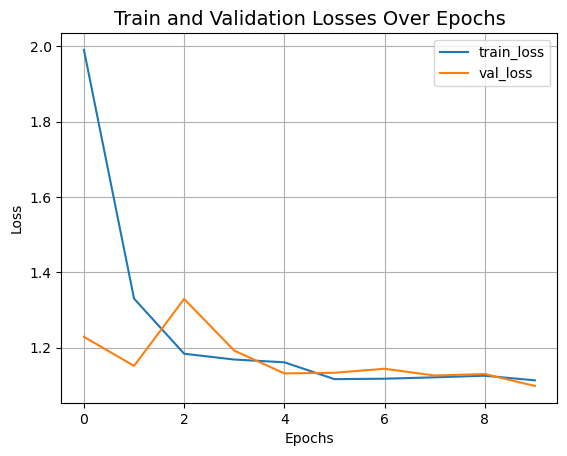

In [19]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [20]:
loss, accuracy, top_3_accuracy = model.evaluate(x_test, y_test_one_hot)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 3 accuracy: {round(top_3_accuracy * 100, 2)}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 484ms/step - accuracy: 0.3838 - loss: 1.0922 - top-3-accuracy: 1.0000
Test loss: 1.1
Test accuracy: 39.33%
Test top 3 accuracy: 100.0%


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 965ms/step


Text(0.5, 1.0, 'Confusion Matrix')

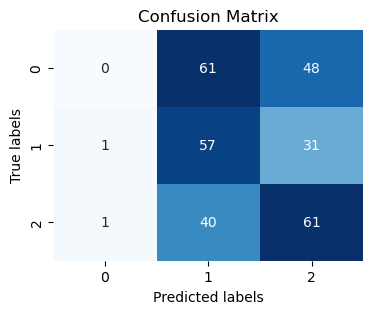

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(x_test)
y_pred = np.argmax (y_pred, axis = 1)
y_test = np.squeeze(y_test)
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

In [22]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report) 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.36      0.64      0.46        89
           2       0.44      0.60      0.50       102

    accuracy                           0.39       300
   macro avg       0.27      0.41      0.32       300
weighted avg       0.26      0.39      0.31       300

